In [143]:
import os
import dataset
import numpy as np
import torch
import nibabel as nib
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from random import randint
import random

In [144]:
root_dir = './'

In [145]:
args = {
  "img_size": [
    256,
    256
  ],
  "Batch_Size": 1,
  "EPOCHS": 4000,
  "T": 1000,
  "base_channels": 128,
  "beta_schedule": "linear",
  "channel_mults": "",
  "loss-type": "l2",
  "loss_weight": "none",
  "train_start": True,
  "lr": 1e-4,
  "random_slice": False,
  "sample_distance": 800,
  "weight_decay": 0.0,
  "save_imgs": False,
  "save_vids": True,
  "dropout": 0,
  "attention_resolutions": "16,8",
  "num_heads": 2,
  "num_head_channels": -1,
  "noise_fn": "simplex",
  "dataset": "mri"
}

In [146]:
def plot_tensor(tensor):
    array = tensor.numpy()
    array = array.transpose(1, 2, 0)
    plt.imshow(array, cmap= 'gray')
    plt.axis('off')  # Optional: turn off the axis
    plt.show()

In [147]:
train_dataset, test_dataset = dataset.init_datasets(root_dir, args)

In [149]:
# for i in train_dataset:
#     plot_tensor(i['image'])

In [150]:
# import tarfile

# # Specify the path to your tar file
# tar_file_path = r"C:\Users\Admin\Dropbox\PC\Documents\Anomaly Detection\AnoDDPM\DATASETS\brats2021\BraTS2021_Training_Data.tar"
# p = r"C:\Users\Admin\Dropbox\PC\Documents\Anomaly Detection\AnoDDPM\DATASETS\ANNO2021B"
# # Open the tar file
# with tarfile.open(tar_file_path, 'r') as tar:
#     # Extract all contents of the tar file
#     tar.extractall(path=p)


In [151]:
path = r"C:\Users\Admin\Dropbox\PC\Documents\Anomaly Detection\AnoDDPM\DATASETS\ANNO2021B"

In [178]:
class MRIDataset(Dataset):
    """Healthy and Anomaly MRI dataset."""

    def __init__(self, ROOT_DIR, transform=False, img_size=(32, 32), random_slice=False, is_anno = False, is_train = True):
        """
        Args:
            ROOT_DIR (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.is_anno = is_anno
        self.transform = transforms.Compose(
                [transforms.ToPILImage(),
                 transforms.CenterCrop(155),
                 transforms.Resize(img_size, transforms.InterpolationMode.BILINEAR),
                 transforms.ToTensor()
                 ]
                ) if transform else False
        split_ratio = 0.5
        train_test_filenames = os.listdir(ROOT_DIR)
        
        random.shuffle(train_test_filenames)
        
        split_index = int(split_ratio * len(train_test_filenames))
        
        training_set = train_test_filenames[:split_index]
        testing_set = train_test_filenames[split_index:]
        
        self.filenames = training_set if is_train else testing_set
        if ".DS_Store" in self.filenames:
            self.filenames.remove(".DS_Store")
        self.ROOT_DIR = ROOT_DIR
        self.random_slice = random_slice
        if is_anno:
            self.shp = (240, 240)
        else:
            self.shp = (256, 256)

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        # print(repr(idx))
        if torch.is_tensor(idx):
            idx = idx.tolist()
        if os.path.exists(os.path.join(self.ROOT_DIR, self.filenames[idx], f"{self.filenames[idx]}.npy")):
            image = np.load(os.path.join(self.ROOT_DIR, self.filenames[idx], f"{self.filenames[idx]}.npy"))
            pass
        else:
            if self.is_anno:
                img_name = os.path.join(
                    self.ROOT_DIR, self.filenames[idx], f"{self.filenames[idx]}_flair.nii.gz"
                )
                img = nib.load(img_name)
                image = img.get_fdata()
                mask_name = os.path.join(
                    self.ROOT_DIR, self.filenames[idx], f"{self.filenames[idx]}_seg.nii.gz"
                )
                mask = nib.load(mask_name)
                mask = mask.get_fdata()
            else:
                img_name = os.path.join(
                    self.ROOT_DIR, self.filenames[idx], f"sub-{self.filenames[idx]}_ses-NFB3_T1w.nii.gz"
                )
                img = nib.load(img_name)
                image = img.get_fdata()                
                mask = torch.zeros(image.shape)
            image_mean = np.mean(image)
            image_std = np.std(image)
            img_range = (image_mean - 1 * image_std, image_mean + 2 * image_std)
            image = np.clip(image, img_range[0], img_range[1])
            image = image / (img_range[1] - img_range[0])
            
#             np.save(
#                     os.path.join(self.ROOT_DIR, self.filenames[idx], f"{self.filenames[idx]}.npy"), image.astype(
#                             np.float32
#                             )
#                     )
        if self.random_slice:
            # slice_idx = randint(32, 122)
            slice_idx = randint(40, 100)
        else:
            slice_idx = 120
        
        image = torch.from_numpy(image[:, :, slice_idx:slice_idx + 1]).float().reshape(self.shp)
#         .reshape(self.shp).astype(np.float32)
        mask = torch.from_numpy(mask[:, :, slice_idx:slice_idx + 1]).float().reshape(self.shp)
#         .reshape(self.shp).astype(np.float32)
        label = 1 if mask.max()>0 else 0
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        sample = {'image': image, "filenames": self.filenames[idx], "mask": mask, "label" : label}
        return sample

In [179]:
mri_dataset = MRIDataset(path, img_size=(256, 256), random_slice=False, is_anno=True, transform= True)

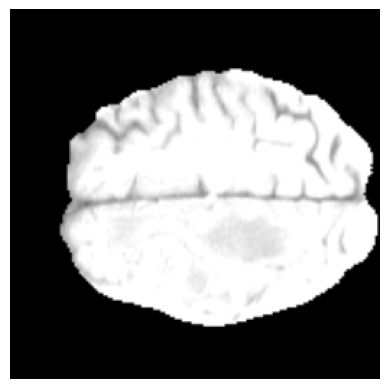

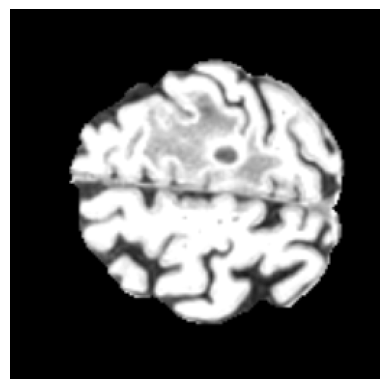

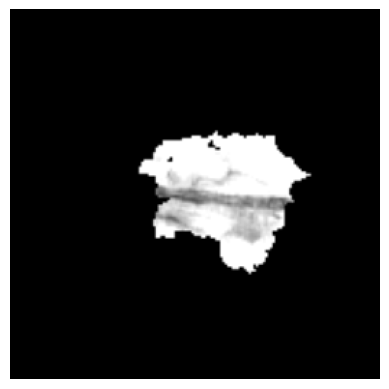

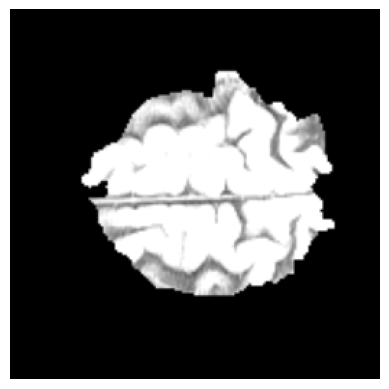

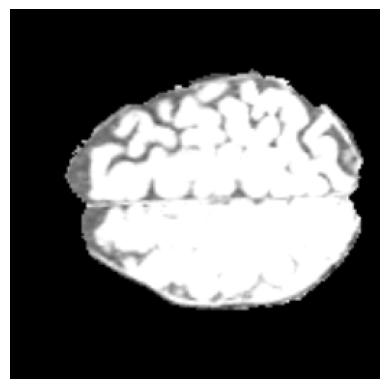

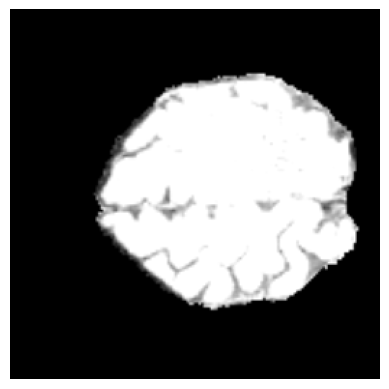

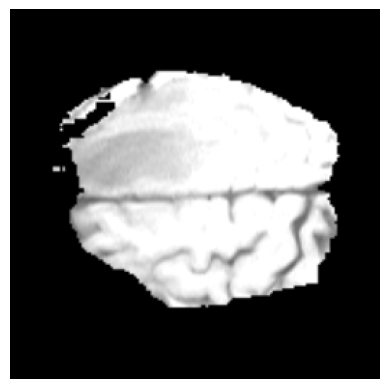

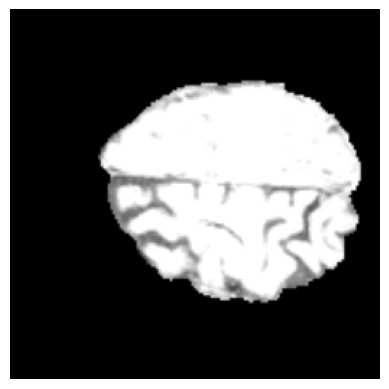

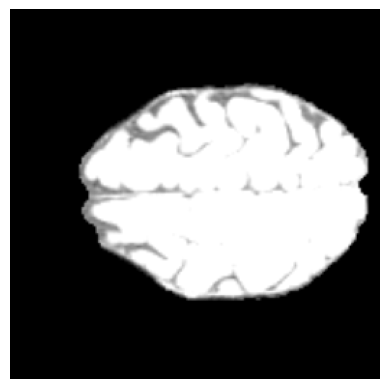

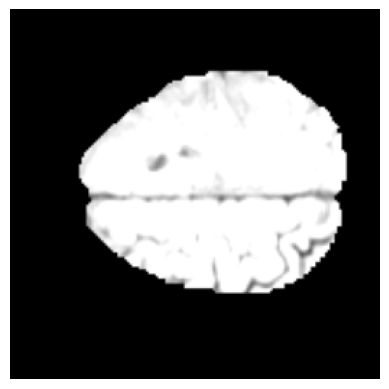

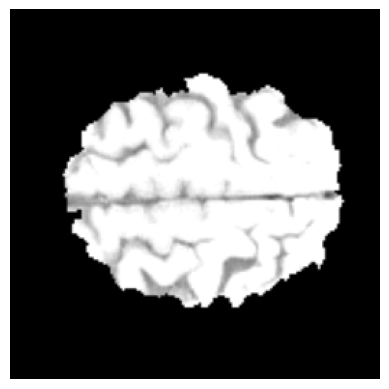

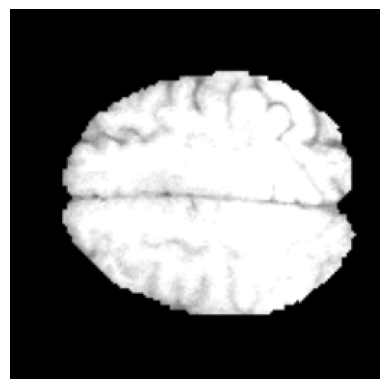

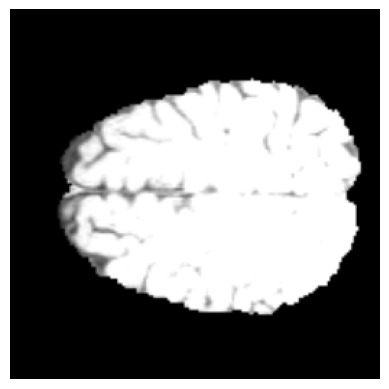

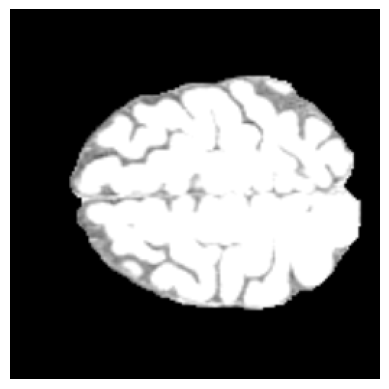

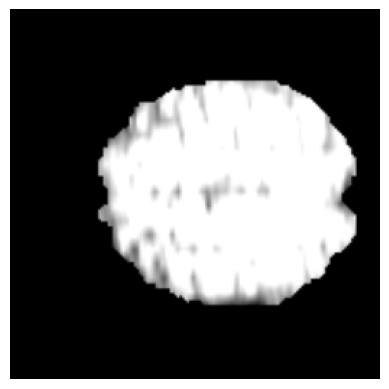

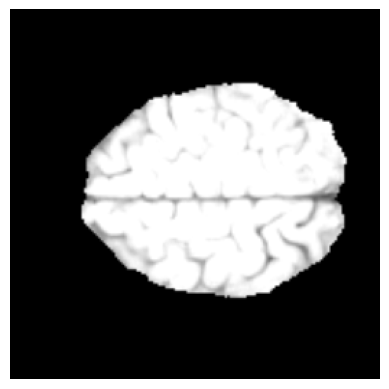

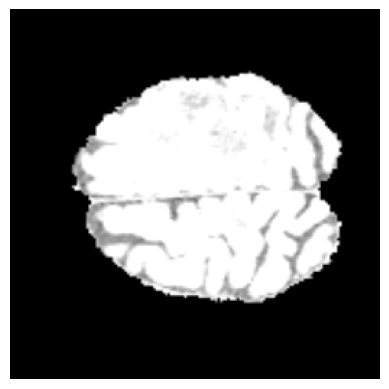

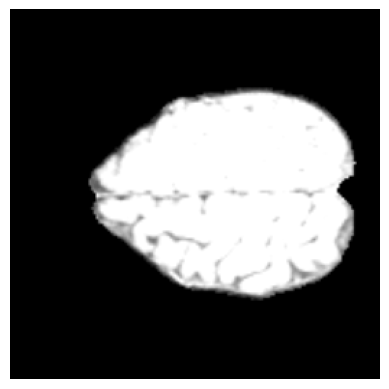

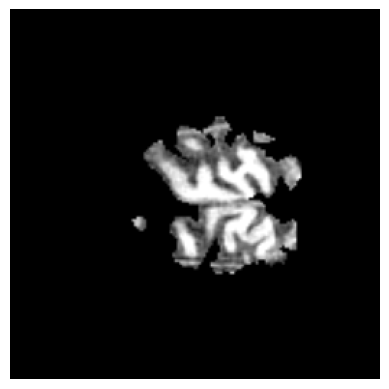

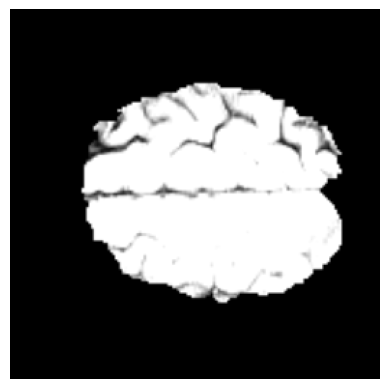

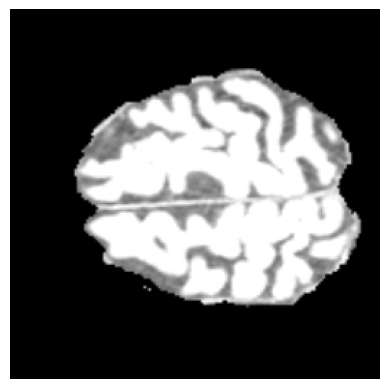

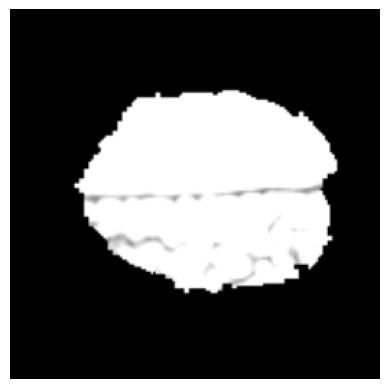

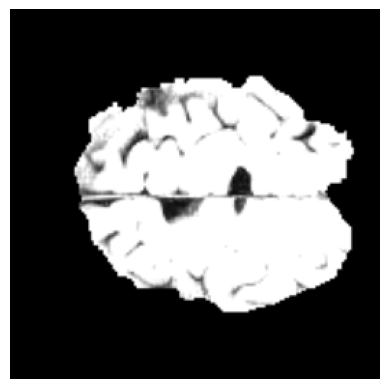

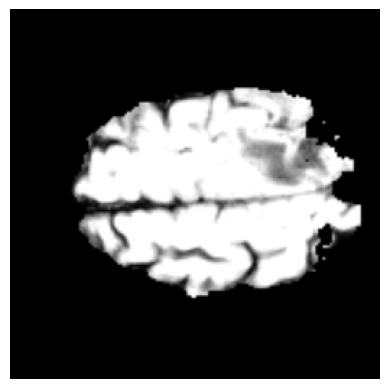

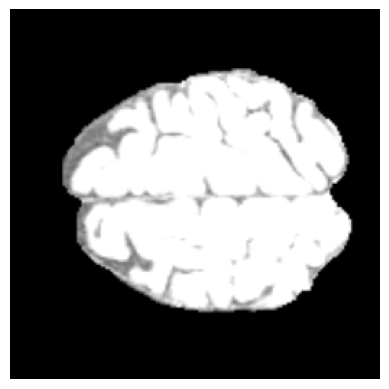

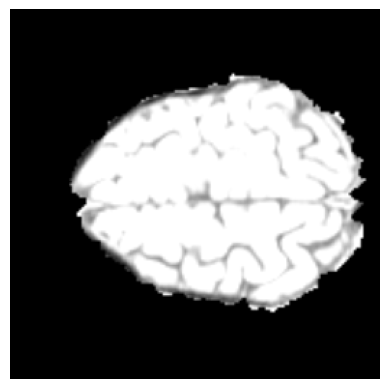

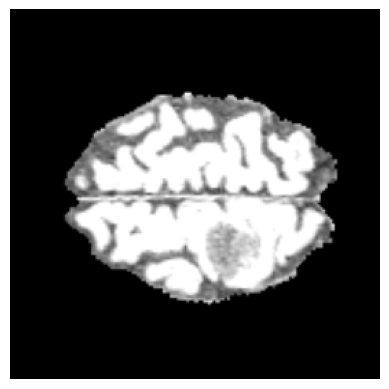

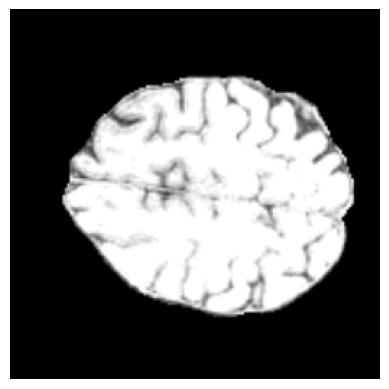

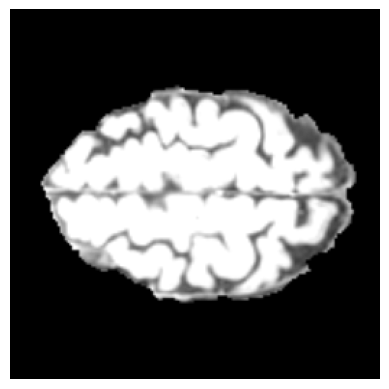

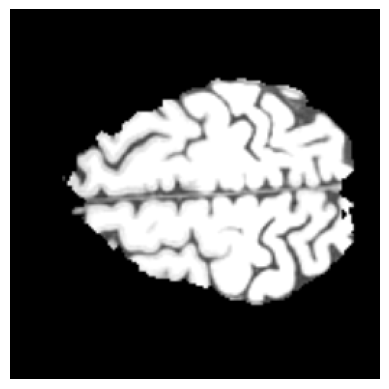

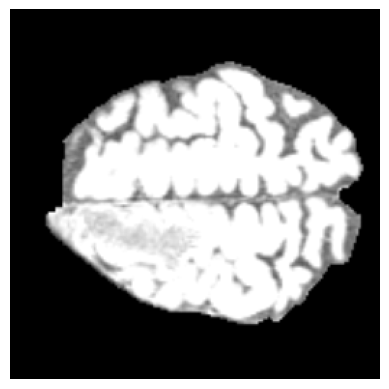

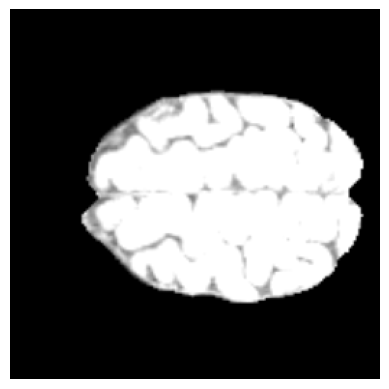

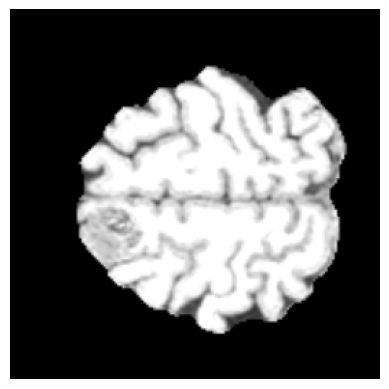

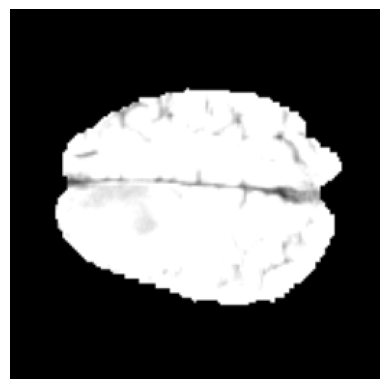

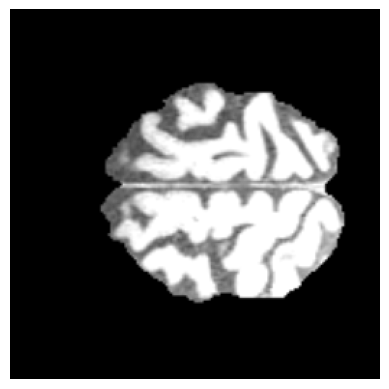

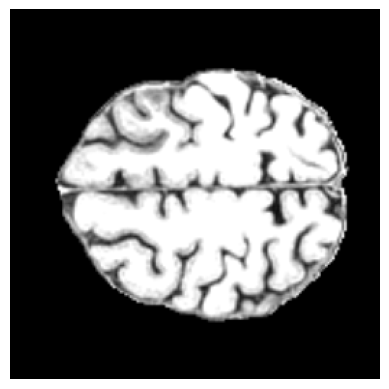

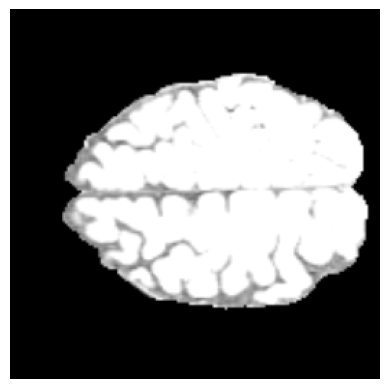

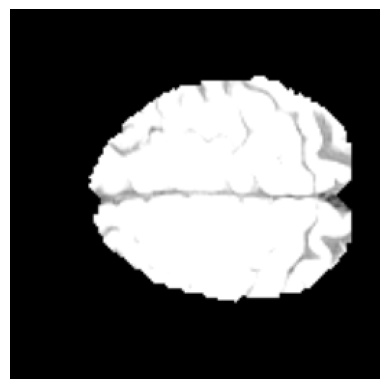

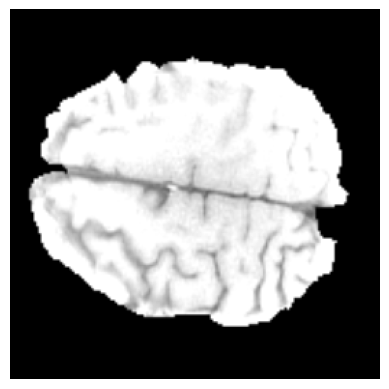

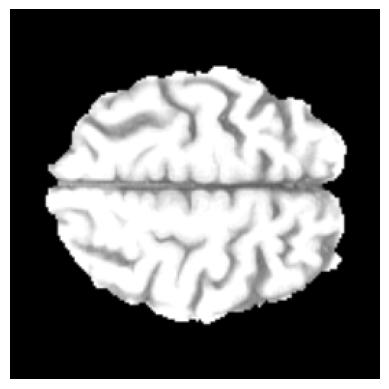

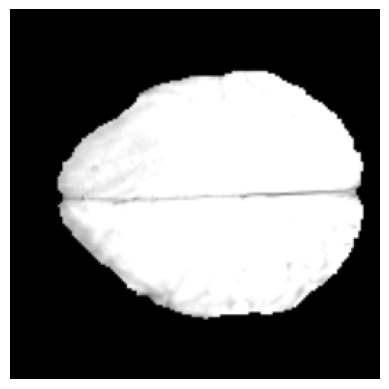

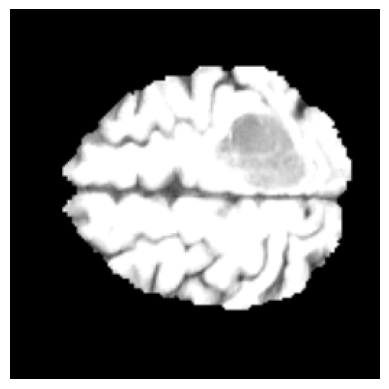

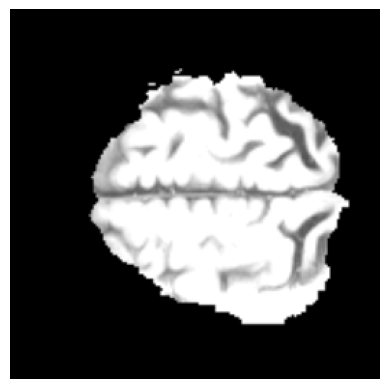

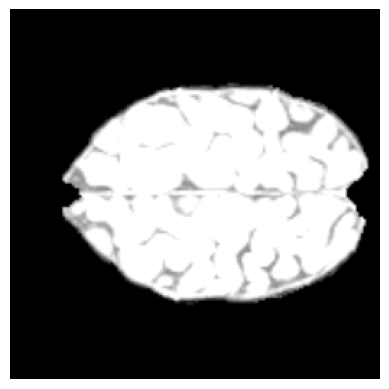

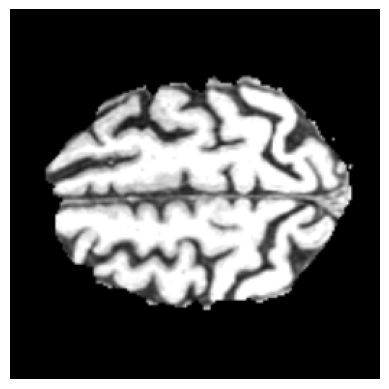

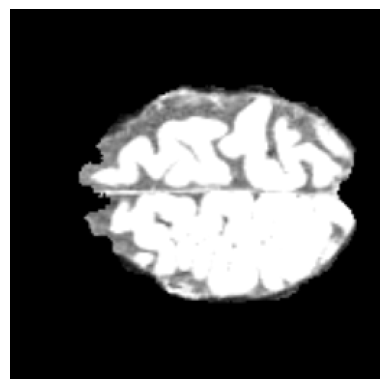

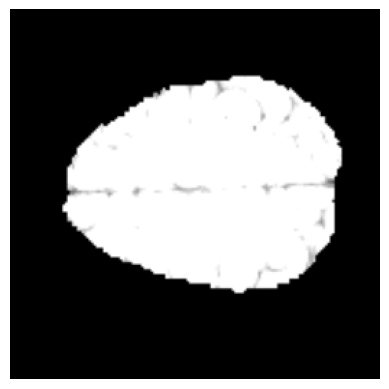

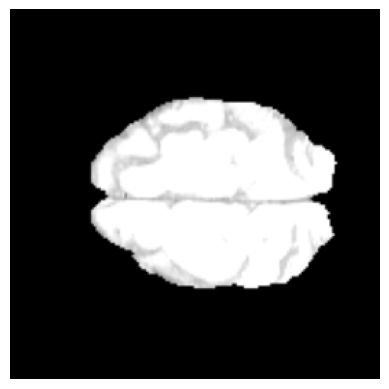

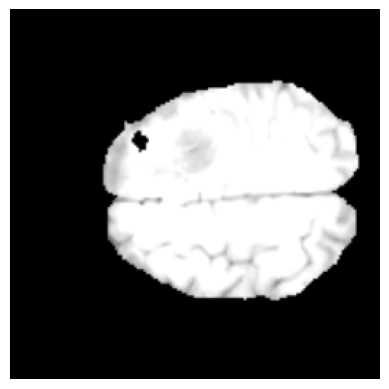

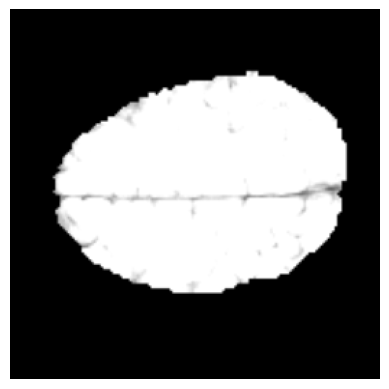

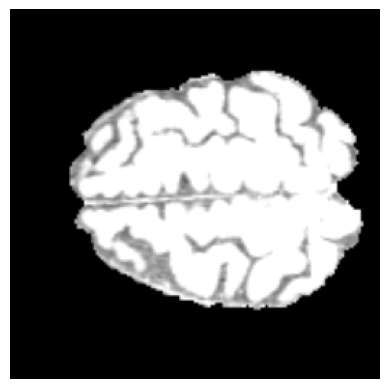

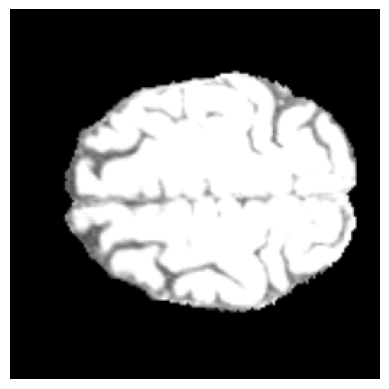

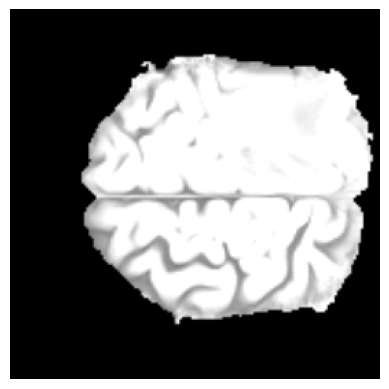

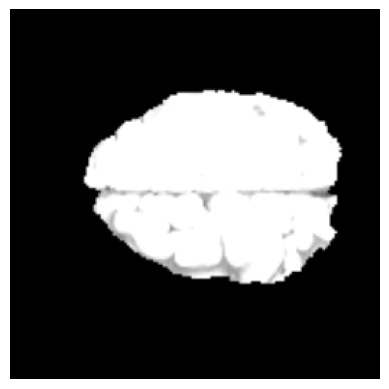

KeyboardInterrupt: 

In [180]:
for i in mri_dataset:
    plot_tensor(i['image'])

In [ ]:
for i in mri_dataset:
    plot_tensor(i['image'])

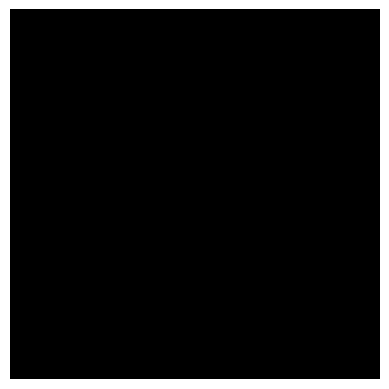

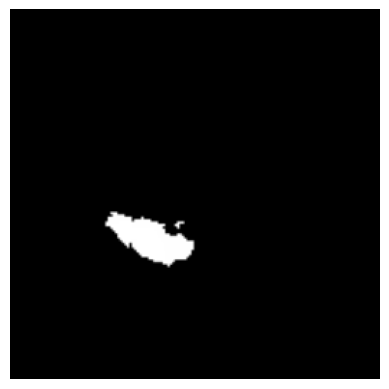

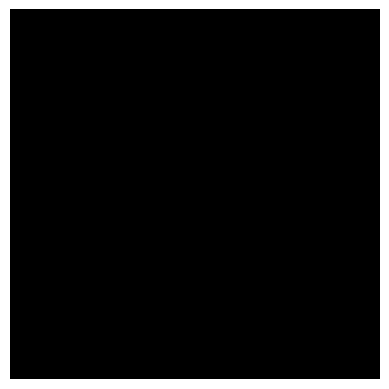

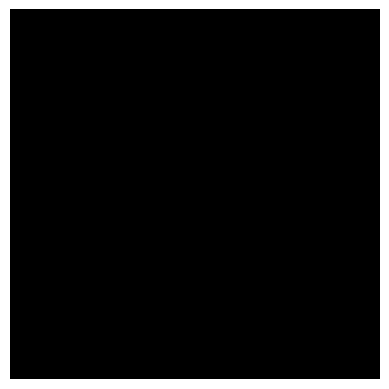

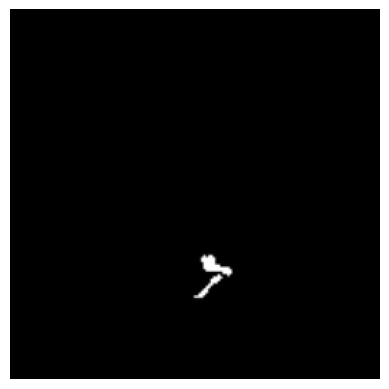

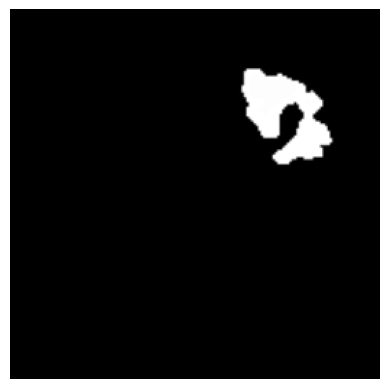

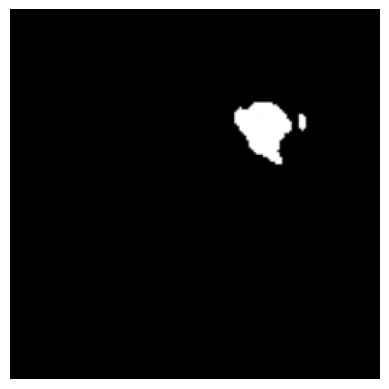

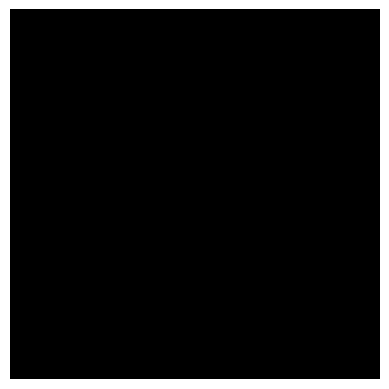

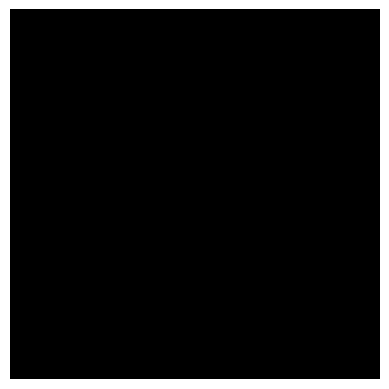

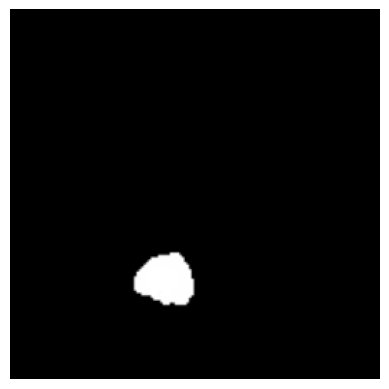

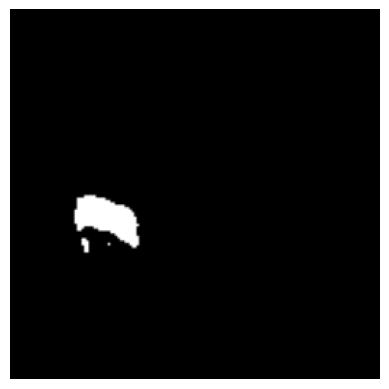

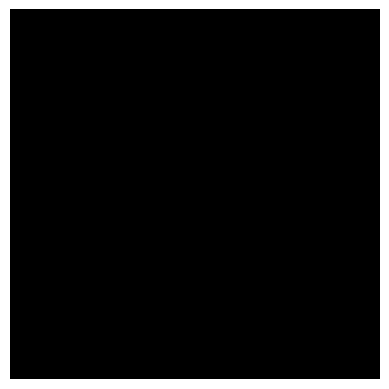

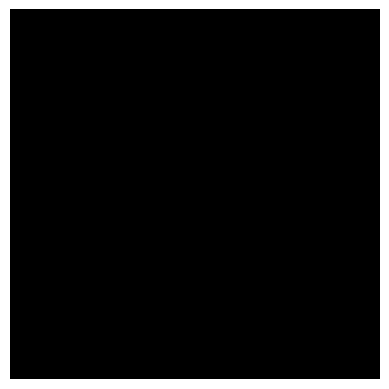

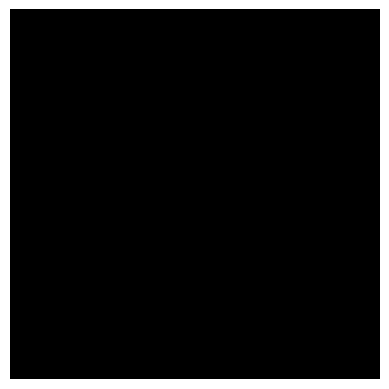

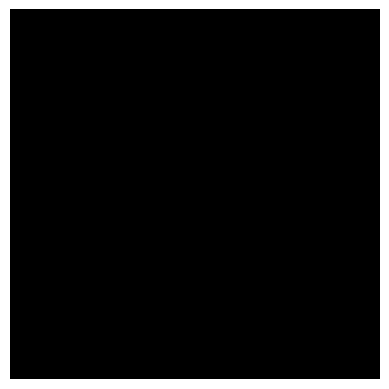

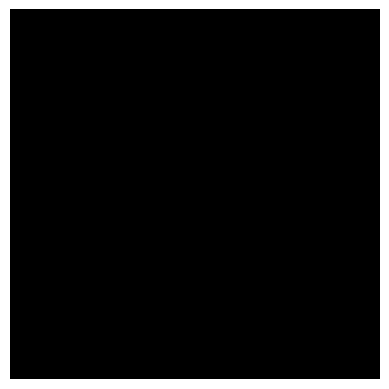

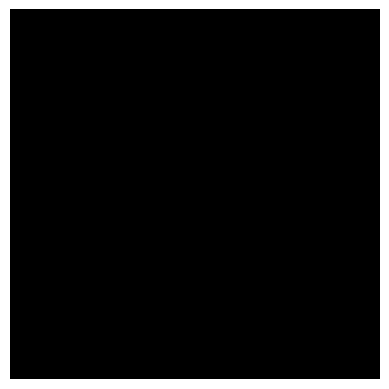

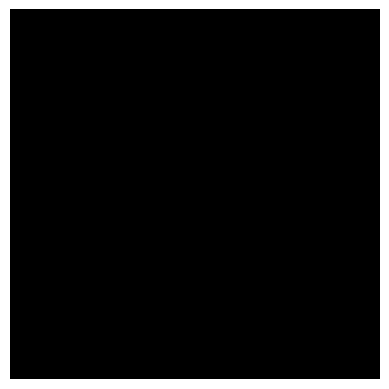

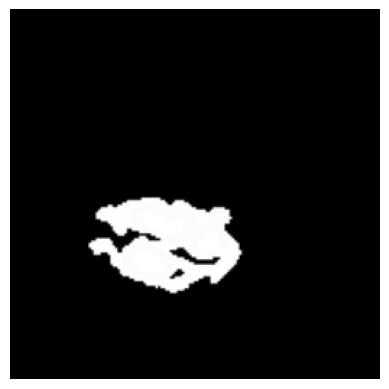

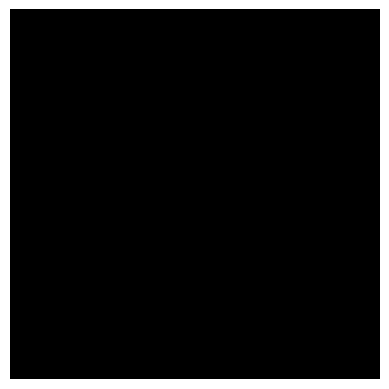

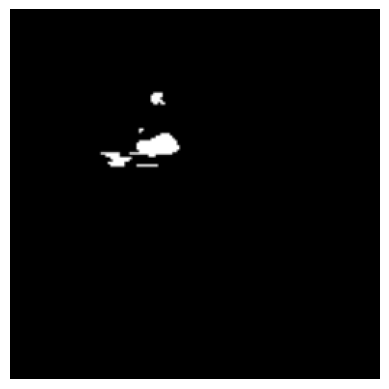

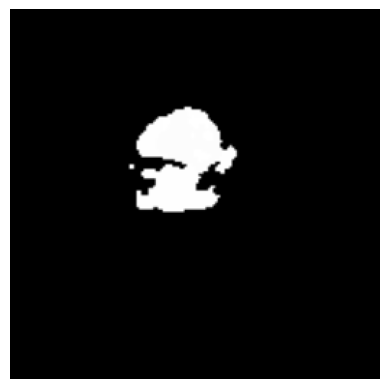

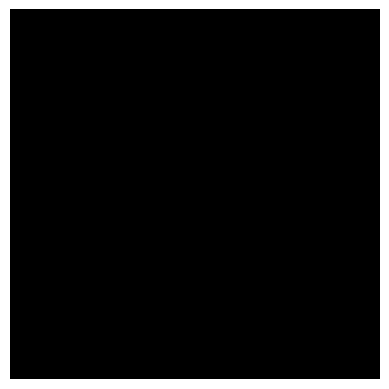

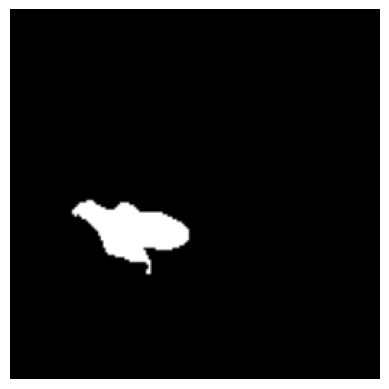

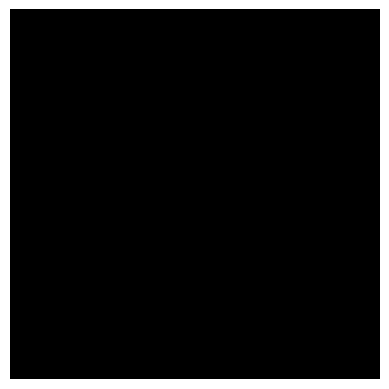

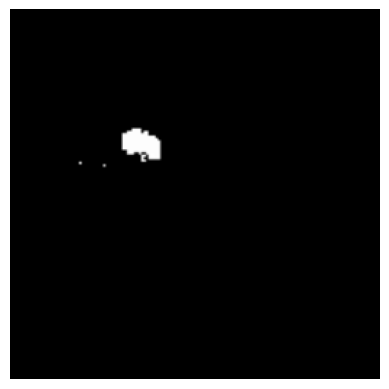

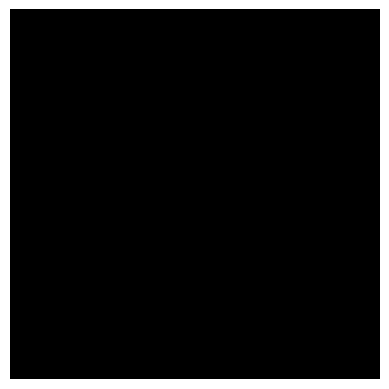

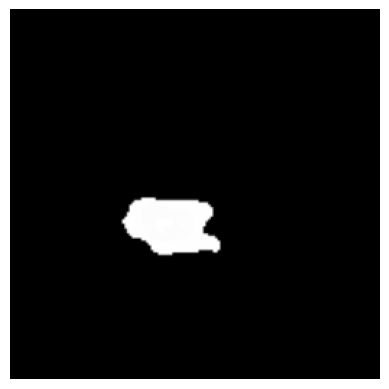

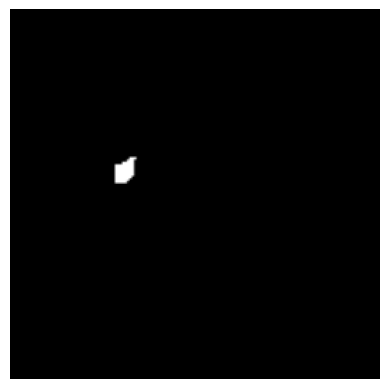

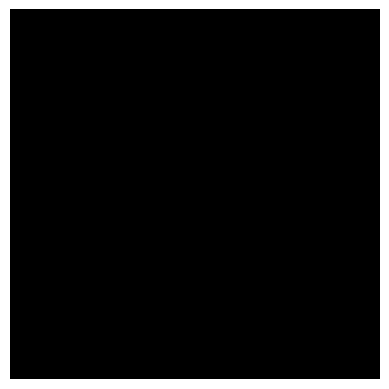

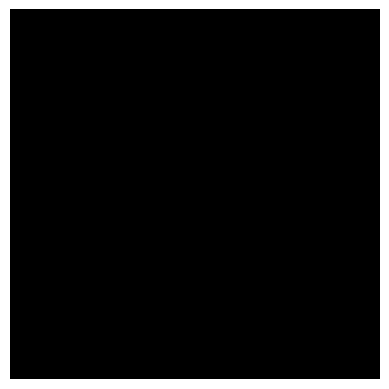

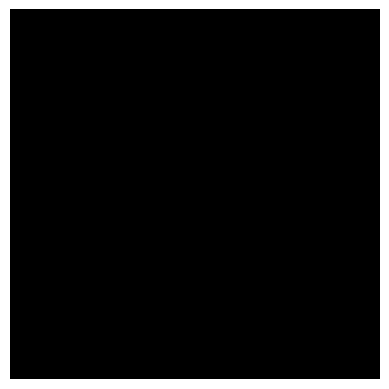

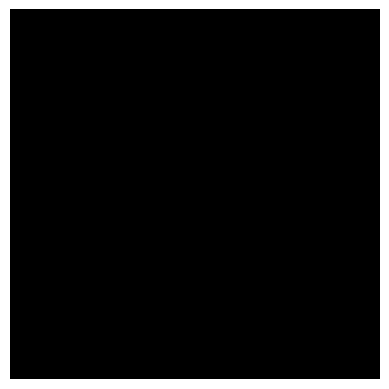

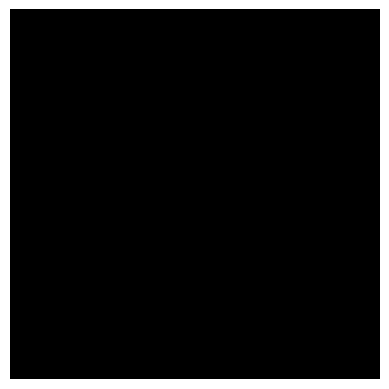

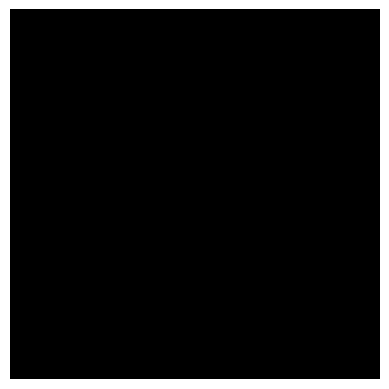

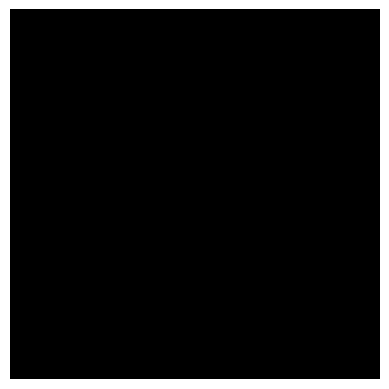

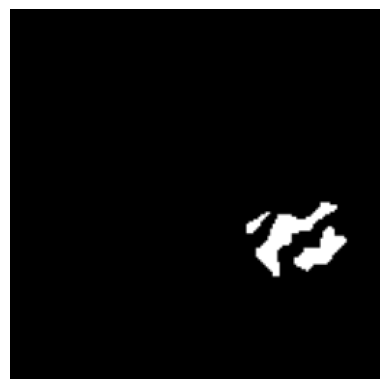

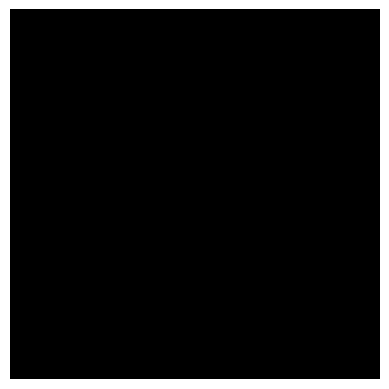

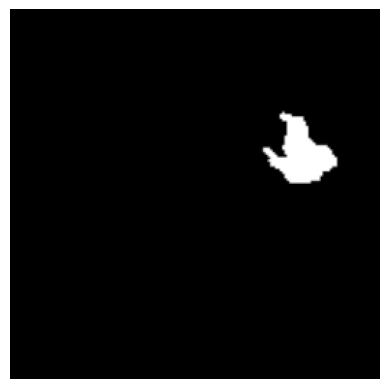

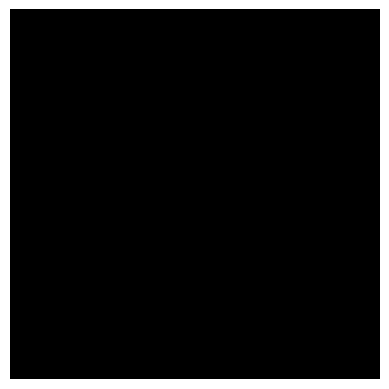

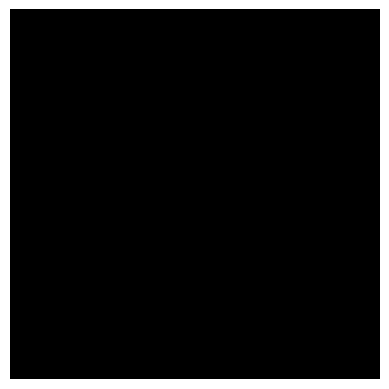

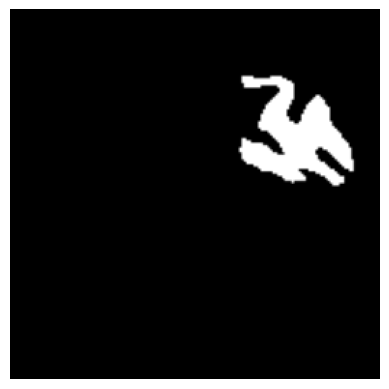

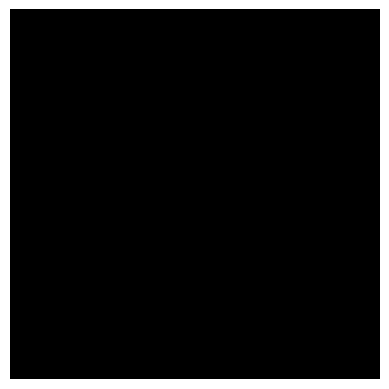

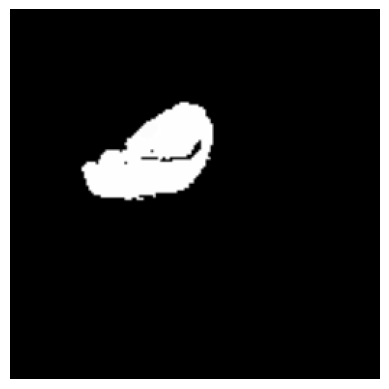

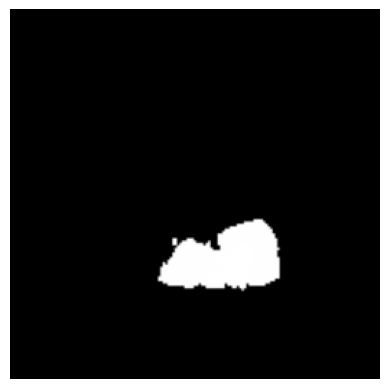

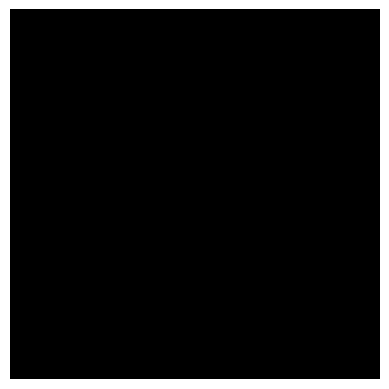

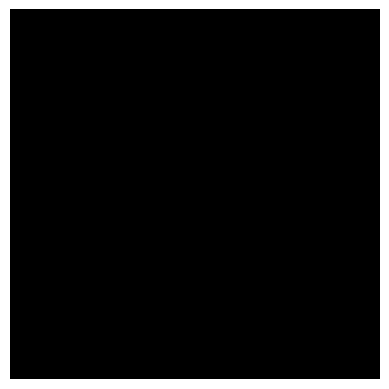

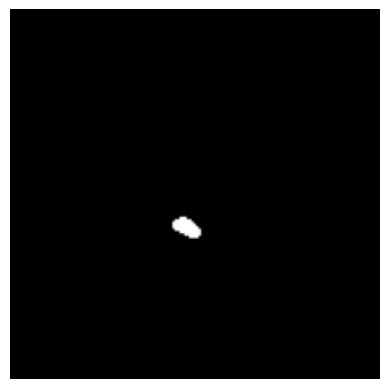

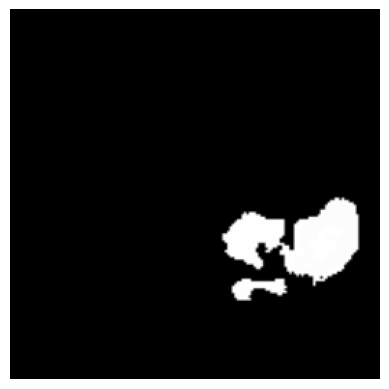

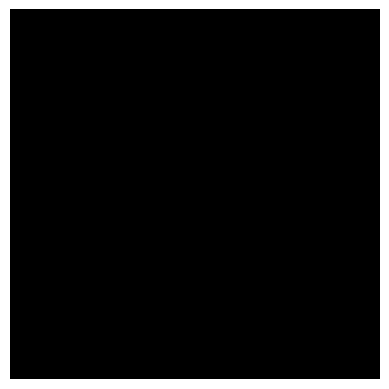

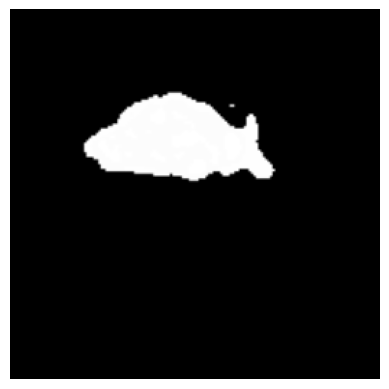

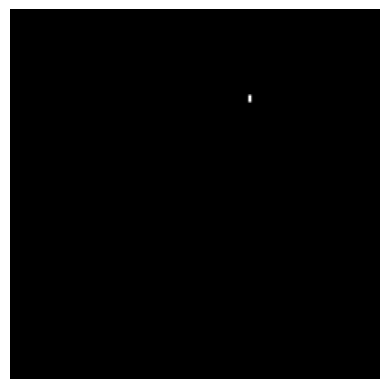

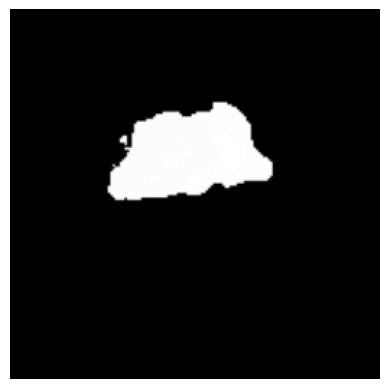

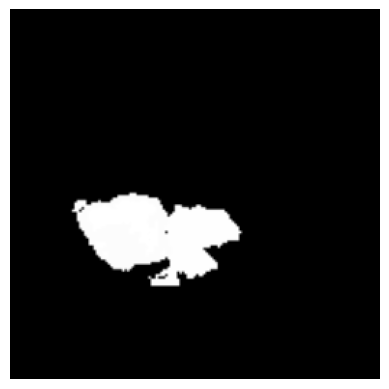

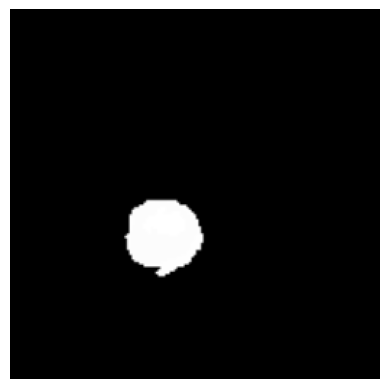

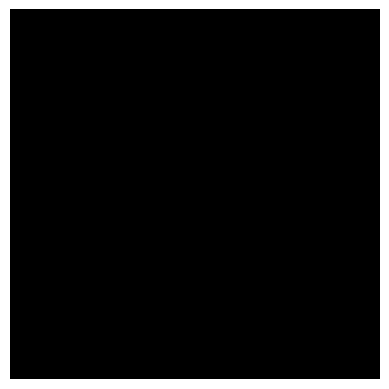

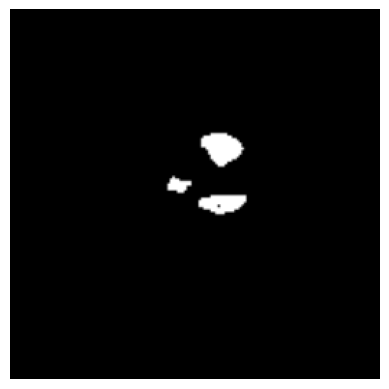

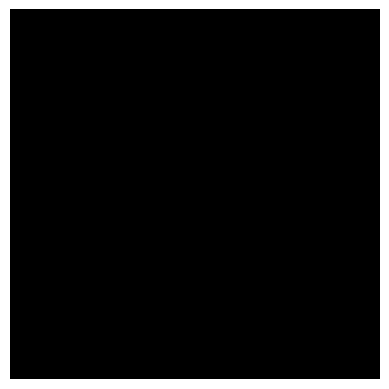

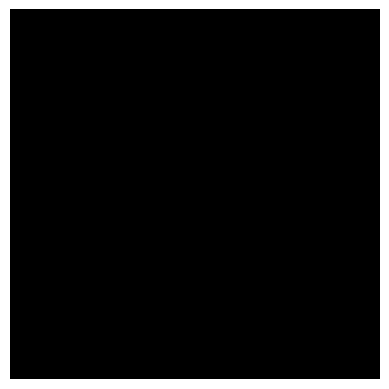

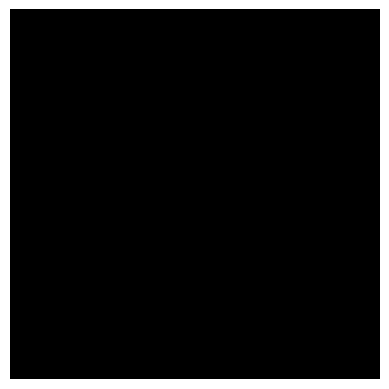

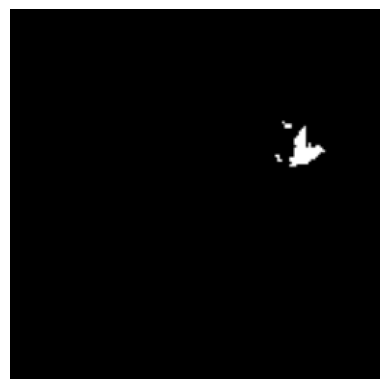

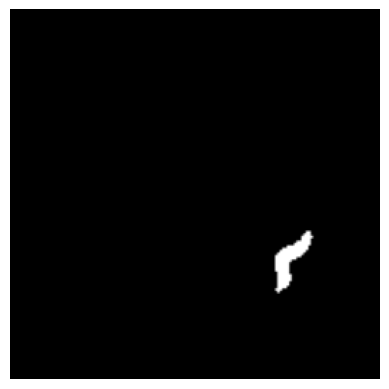

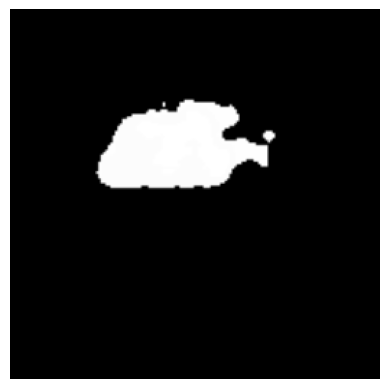

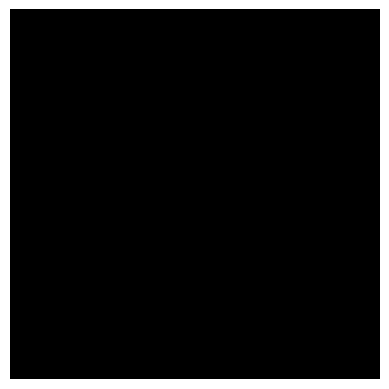

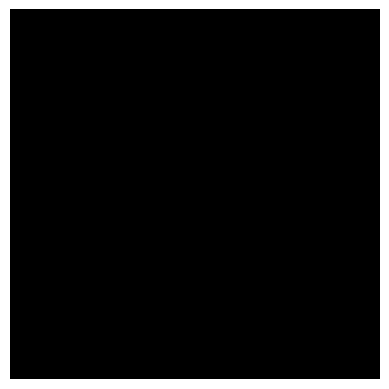

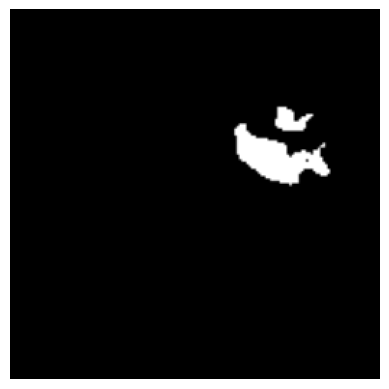

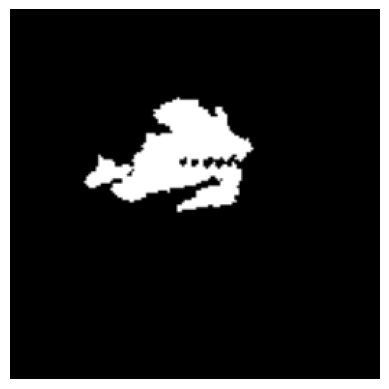

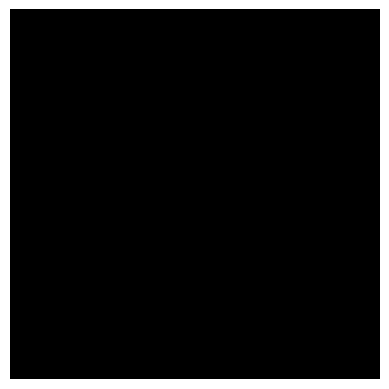

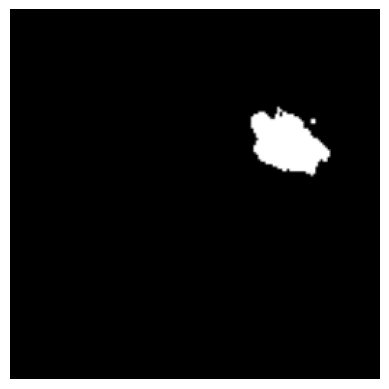

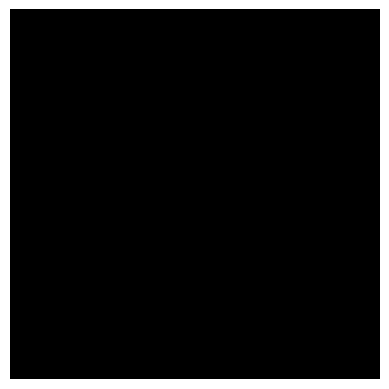

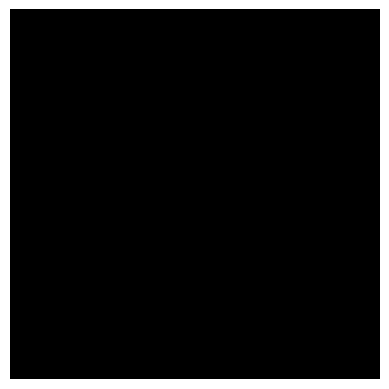

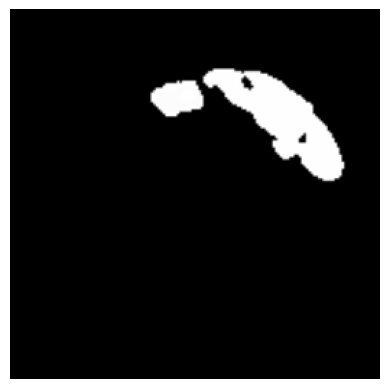

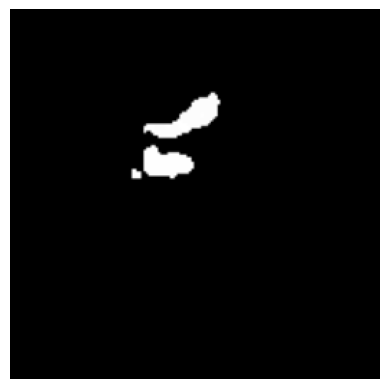

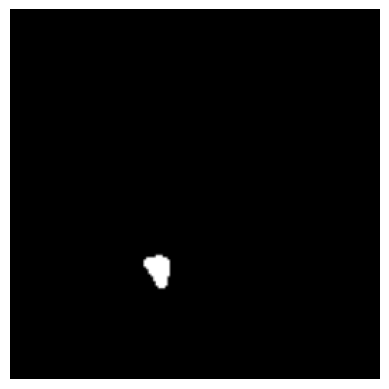

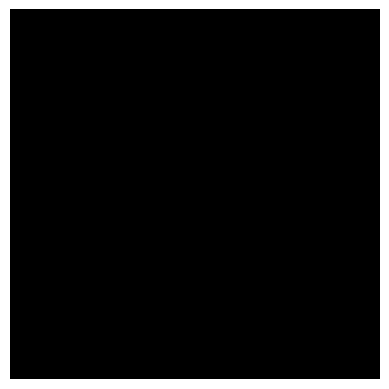

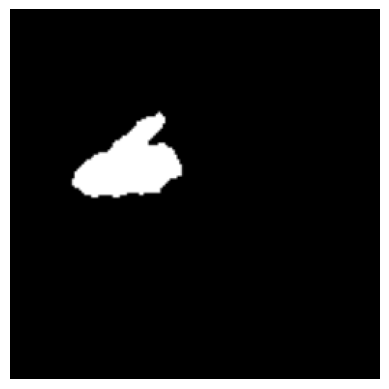

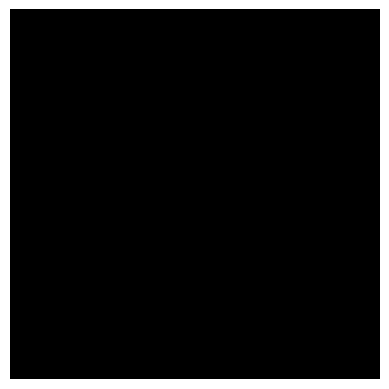

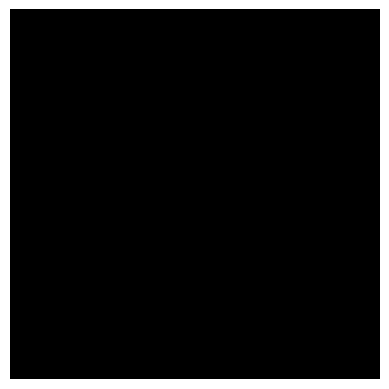

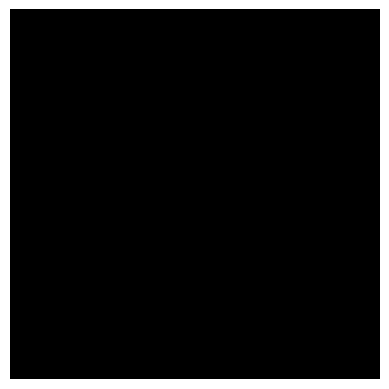

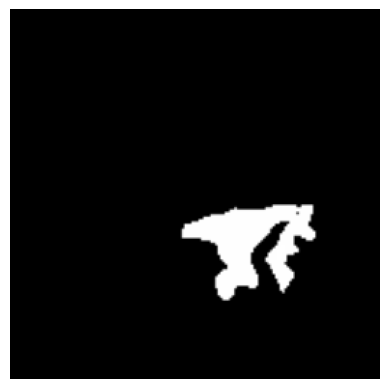

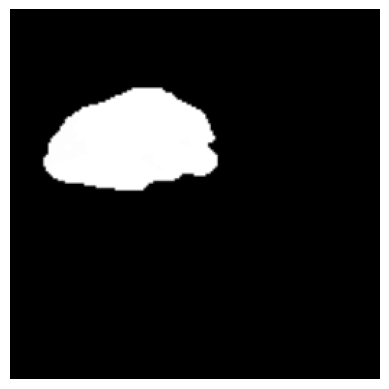

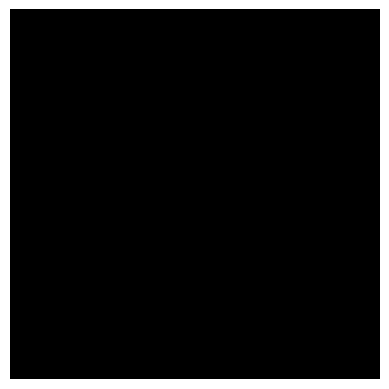

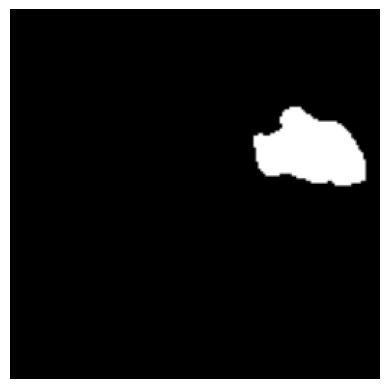

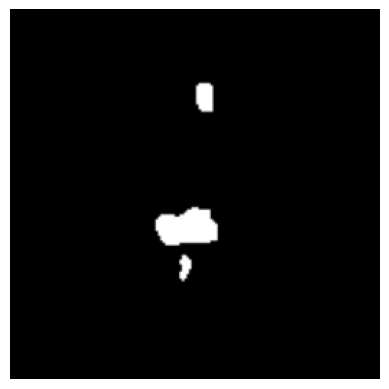

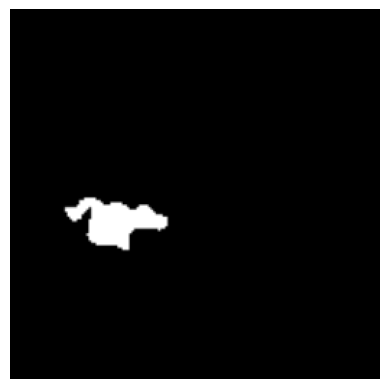

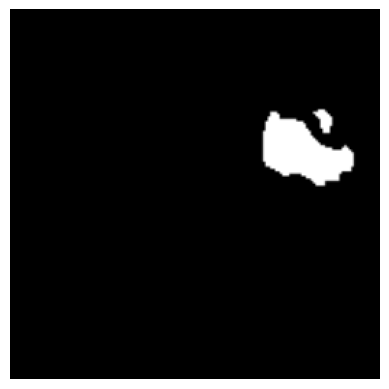

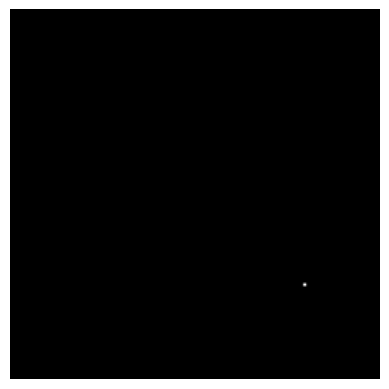

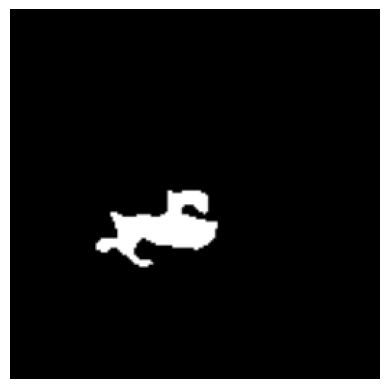

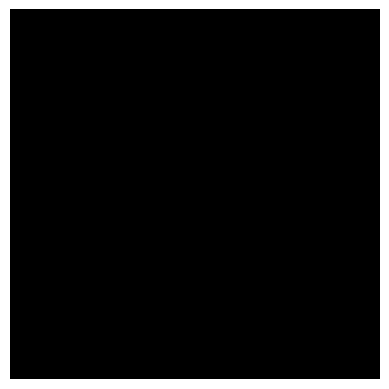

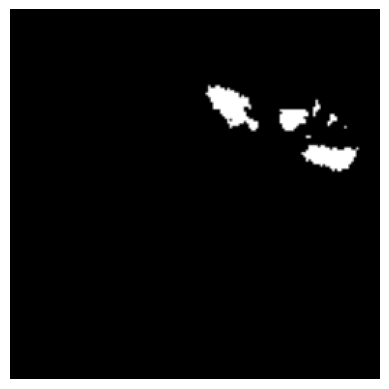

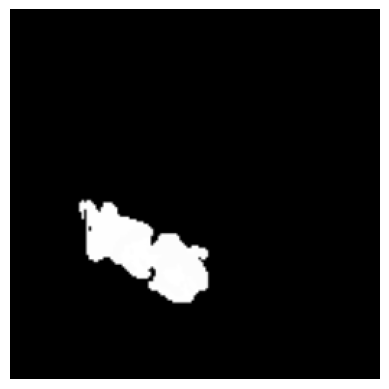

KeyboardInterrupt: 

In [174]:
for i in mri_dataset:
    plot_tensor(i['mask'])

In [123]:
# for i in mri_dataset:
#     print(i['label'])
# #     plot_tensor(i['mask'])

In [129]:
import torch
from torchvision import transforms

# Assuming you have an image tensor called 'image_tensor' with shape [C, H, W]
image_tensor = torch.randn(3, 256, 256)  # Example image tensor

# Define the desired output size for center cropping
crop_size = 224

# Create a CenterCrop transformation
center_crop = transforms.CenterCrop(crop_size)

# Apply center cropping to the image tensor
cropped_image_tensor = center_crop(image_tensor)


In [130]:
cropped_image_tensor.shape

torch.Size([3, 224, 224])